### Set up notebook - imports and paths

In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# matplotlib
import matplotlib.pyplot as plt

# cartopy
import cartopy.crs as ccrs

# extras
import geopandas as gpd
from rasterio.features import geometry_mask
import rioxarray
from shapely.geometry import mapping
from functools import reduce
import odc.geo.xr
import odc.geo.crs as odccrs
from odc.geo.geobox import GeoBox

ERROR 1: PROJ: proj_create_from_database: Open of /cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths

path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

## Import Data

### Read WRF data

In [3]:
## start with importing the precipitation data
# this takes all the files that match this pattern
varname = 'PCPT'
varname = 'T2'
fname_pattern = path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_*.nc'.format(varname)

# this opens all the files and puts them into a single dataset object
wrf = xr.open_mfdataset(fname_pattern, combine='by_coords')

wrf

<xarray.Dataset>
Dimensions:  (time: 350400, y: 250, x: 320)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2019-12-31T23:00:00
    lat      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    T2       (time, y, x) float32 dask.array<chunksize=(8760, 250, 320), meta=np.ndarray>
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Sat Dec  8 15:40:16 AKST 2018

### Play with plotting WRF data

In [4]:
## Open southwest_geo.nc to pull projection information
ds = xr.open_dataset(path_to_data + 'downloads/geo_southeast.nc')
# Define the projection
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = ccrs.LambertConformal(globe=globe, # important!
                            central_longitude=ds.STAND_LON, central_latitude=ds.MOAD_CEN_LAT,
                            standard_parallels=(ds.TRUELAT1, ds.TRUELAT2),
                            )
datacrs = ccrs.PlateCarree()
mapcrs = ccrs.PlateCarree()

In [5]:
test = wrf.sel(time='2018-01-15 06:00') # select a single time step from WRF data
test

<xarray.Dataset>
Dimensions:  (y: 250, x: 320)
Coordinates:
    time     datetime64[ns] 2018-01-15T06:00:00
    lat      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    T2       (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Sat Dec  8 15:40:16 AKST 2018

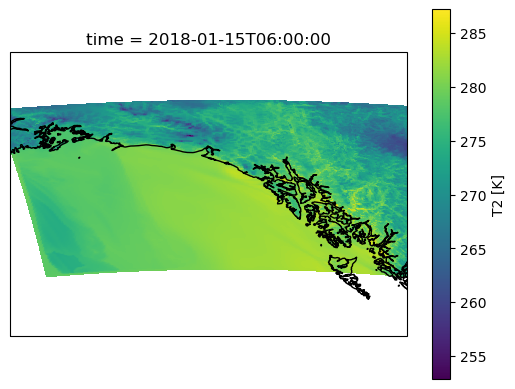

In [6]:

p = test[varname].plot(x='lon', y='lat',
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},
)  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines()
p.axes.set_extent([-150, -129, 50, 65])

### Open Watershed Data

In [7]:
## use geopandas to import the watershed shapefile
fp = path_to_data + 'downloads/USFS_SEAK_WS/USFS_Southeast_Alaska_Drainage_Basin_(SEAKDB)_Watersheds.shp'
polys = gpd.read_file(fp, crs="epsg:4326") # have to manually set the projection
polys

,OBJECTID,Hectares,SHAPE__Are,SHAPE__Len,geometry
0,1,4.551987e+03,1.421039e+08,6.377556e+04,"POLYGON ((-132.86421 55.57149, -132.86431 55.5..."
1,2,3.709807e+03,1.141630e+08,7.346113e+04,"POLYGON ((-131.30430 55.32201, -131.30349 55.3..."
2,3,6.706178e+01,2.064087e+06,6.344688e+03,"POLYGON ((-131.53448 55.29386, -131.53452 55.2..."
3,4,3.685783e+03,1.130811e+08,6.806210e+04,"POLYGON ((-131.20469 55.19304, -131.20470 55.1..."
4,5,5.832713e+03,1.787272e+08,1.122791e+05,"POLYGON ((-131.38853 55.19235, -131.39028 55.1..."
...,...,...,...,...,...
2448,2469,3.601402e+02,1.177469e+07,2.267321e+04,"POLYGON ((-132.38304 56.48924, -132.38282 56.4..."
2449,2470,3.034444e+03,1.001343e+08,5.984970e+04,"POLYGON ((-132.53418 56.68707, -132.53387 56.6..."
2450,2471,2.902639e+03,8.763146e+07,9.229852e+04,"POLYGON ((-130.41699 54.94616, -130.41656 54.9..."
2451,2472,2.782979e+02,8.690325e+06,2.247218e+04,"POLYGON ((-133.10408 55.59233, -133.10357 55.5..."


In [8]:
## lets pick the biggest watershed for this example because it will be nice to visualize
idx = polys['Hectares'].idxmax() # finding the ID where the size is the biggest
data = polys.iloc[idx] # select that row from the dataframe
data # display

OBJECTID                                                   1679
Hectares                                         5088119.046422
SHAPE__Are                                  177107890764.562988
SHAPE__Len                                       4280537.707485
geometry      POLYGON ((-130.244633031932 56.7304808472168, ...
Name: 1671, dtype: object

## Play with plotting shapefile

In [9]:
## select single watershed
idx = polys['OBJECTID']== data.OBJECTID # we want the watershed with this OBJECTID
watershed = polys.loc[idx] # now select only that watershed from all the watersheds

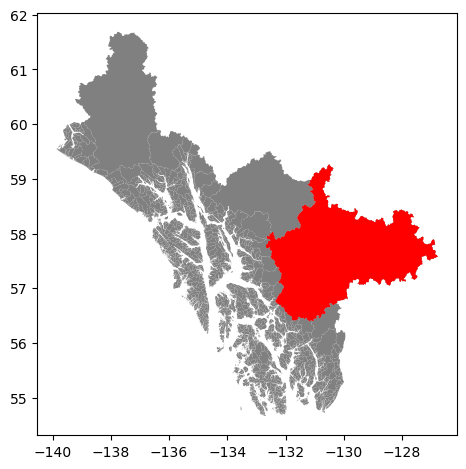

In [10]:
## plot single watershed highlighted
fig, ax = plt.subplots() # initiates a figure
polys.plot(ax=ax, facecolor='gray'); # plots all watersheds in grey
watershed.plot(ax=ax, facecolor='red'); # plots isolated watershed in red
plt.tight_layout(); # cuts white space from fig

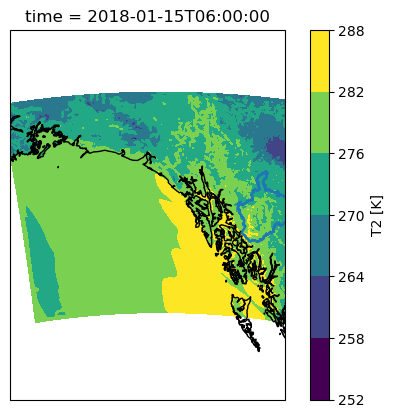

In [11]:
## now plot the single watershed on top of the WRF data

p = test[varname].plot.contourf(x='lon', y='lat', # creating a contour plot
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},)  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines() # add in coastlines so we know where we are
p.axes.set_extent([-150, -129, 50, 65])

watershed.boundary.plot(ax=p.axes); # plots only boundary of isolated watershed

## Crop WRF data to the shape of the watershed

In [12]:
ds = test # raster_mask
gdf = watershed # vector_mask

min_x, min_y, max_x, max_y = gdf.total_bounds
clipped  = ds.where((ds.lon<=max_x) & (ds.lon>=min_x) & (ds.lat<=max_y) & (ds.lat>=min_y), drop=True)

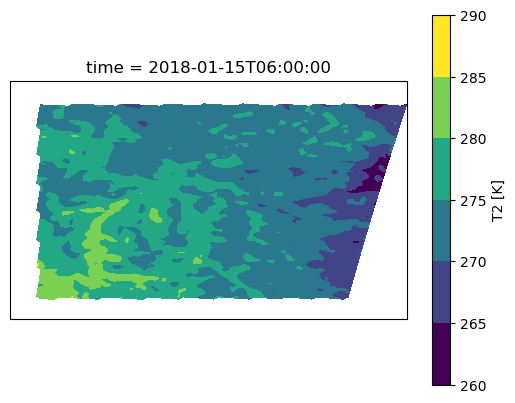

In [13]:
p = clipped[varname].plot.contourf(x='lon', y='lat', # creating a contour plot
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},)  # the plot's projection

In [15]:
ds = test # raster_mask
gdf = watershed # vector_mask

# we need to manually set the coordinate reference system because this data does not have it attached
ds.rio.write_grid_mapping(inplace=True)
ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
ds.rio.write_crs("epsg:4326", inplace=True) # manually setting the projection of the wrf data

clipped = ds.rio.clip(gdf.geometry.apply(mapping), ds.rio.crs, drop=False)
clipped = ds.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=False)

In [18]:
np.nanmax(clipped.T2.values)

/tmp/ipykernel_764/1821922989.py:1: RuntimeWarning: All-NaN slice encountered
  np.nanmax(clipped.T2.values)


nan

/cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


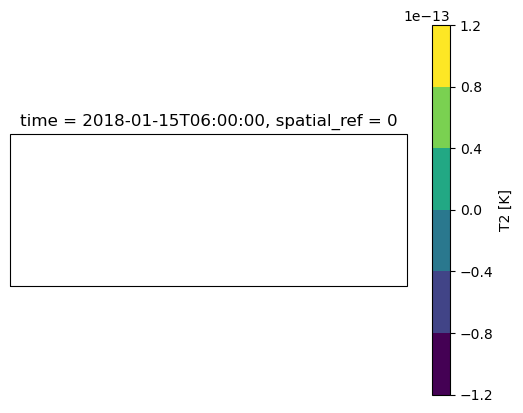

In [29]:
p = clipped[varname].plot.contourf(x='lon', y='lat', # creating a contour plot
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},)  # the plot's projection

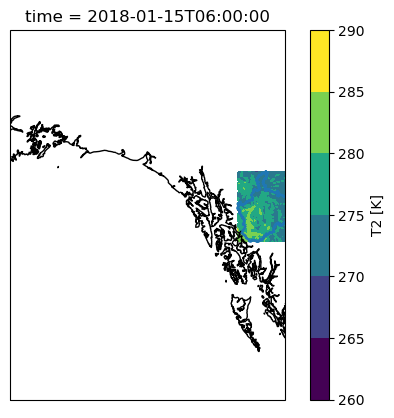

In [14]:
## plot masked WRF data
## overplot watershed too!
p = clipped[varname].plot.contourf(x='lon', y='lat', # creating a contour plot
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},)  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines() # add in coastlines so we know where we are
p.axes.set_extent([-150, -129, 50, 65])

watershed.boundary.plot(ax=p.axes); # plots only boundary of isolated watershed

In [17]:
## take the sum of the precipitation of the masked WRF data
test_sum = clipped[varname].sum(['y', 'x'])
test_sum.values
## note there wasn't any precipitation on this day within this watershed

array(0., dtype=float32)

## Make a function and iterate!

In [14]:
## write a function and then loop through the above sequence for each watershed

def clip_ds_shapefile(ds, gdf):
    """clip_ds_shapefile
    
    Returns a masked xarray ds object for the shape of the given watershed
    
    Parameters
    ----------
    ds : xarray dataset
    gdf : single geopandas object
  
    Returns
    -------
    ds : xarray dataset object
    
    """
    
    # we need to manually set the coordinate reference system because this data does not have it attached
    ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True) # manually setting the projection of the wrf data

    clipped = ds.rio.clip(gdf.geometry.apply(mapping), ds.rio.crs, drop=False)
    
    return clipped

In [15]:
%%time
object_lst = [4, 8, 10]

prec_lst = [] # make an empty list to append the data we want
for i, objectID in enumerate(object_lst): # iterate through the watersheds
    idx = polys['OBJECTID'] == objectID # get watershed with the objectID
    watershed = polys.loc[idx] # select that row from the dataframe
    
    watershedID = watershed.OBJECTID
    print('Processing watershed: ', objectID)
    clipped_ds = clip_ds_shapefile(wrf, watershed)
    
    var_sum = clipped_ds.sum(['lat', 'lon'])
    # convert the precipitation sum to a dataframe
    var_final = var_sum.prec.values
    var_lst.append(var_final)

Processing watershed:  4
Processing watershed:  8
Processing watershed:  10
CPU times: user 4min 54s, sys: 11min 55s, total: 16min 50s
Wall time: 11min 40s


In [16]:
## build a dictionary from our saved data
dicts = {}
keys = object_lst # column names
values = var_lst
for i, key in enumerate(keys):
        dicts[key] = values[i]

## put dictionary into single dataframe
df = pd.DataFrame(data=dicts)

df['time'] = wrf.time.values
df

,4,8,10,time
0,0.000000,0.0,0.0,1980-01-01 00:00:00
1,0.000000,0.0,0.0,1980-01-01 01:00:00
2,0.000000,0.0,0.0,1980-01-01 02:00:00
3,0.000000,0.0,0.0,1980-01-01 03:00:00
4,0.000000,0.0,0.0,1980-01-01 04:00:00
...,...,...,...,...
341635,3.515625,0.0,0.0,2018-12-31 19:00:00
341636,4.125000,0.0,0.0,2018-12-31 20:00:00
341637,5.007812,0.0,0.0,2018-12-31 21:00:00
341638,5.593750,0.0,0.0,2018-12-31 22:00:00


In [17]:
## save as csv file
## save to csv file
df.to_csv(path_to_out + 'watershed_{0}.csv'.format(varname))